# Find out Blended stars

Today our job is to find out blending stars and distinguish them with the true signals.

When two stars are close to each other in the CCD, part of their lights may fall into the same pixel. 
If one of the star has a eclipsing signal, the others will see a similar signal in their light curves. **Usually the mirrored signal will be more diluted than the main signal**. But there could be exceptions.   

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
%matplotlib inline

/Users/chelsea/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Let's create two stars as if their point spread functions (PSFs) are one-d gaussians with full width half maximum (FWHM) of 1.2 pixels, which means sigma ~0.5 pixel. Star one is twice the brightness as star two, and the two stars are one pixel apart. Note I haven't pixelize the flux in the left figure below.

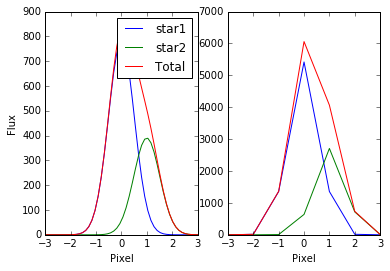

In [2]:
from scipy.stats import norm
FWHM=1.2
x=np.linspace(-3,3,50)
rv = norm(scale=FWHM/2.35)
starone=rv.pdf(x)*1000.
rv = norm(scale=FWHM/2.35)
startwo=(rv.pdf(x-1.0))*500.
fig=plt.figure()
ax=fig.add_subplot(121)
ax.plot(x,starone,label="star1")
ax.plot(x,startwo,label="star2")
ax.plot(x,starone+startwo,label="Total")
ax.set_xlabel("Pixel")
ax.set_ylabel("Flux")
ax.legend()
x_pixel=np.arange(7)-3
def pixelize(x,flux,x_pixel):
    flux_pixel=np.zeros(len(x_pixel))
    for i in xrange(len(x_pixel)):
        index=(x>=x_pixel[i]-0.5)*(x<x_pixel[i]+0.5) 
        flux_pixel[i]=np.sum(flux[index])
    return flux_pixel
starone_pixel=pixelize(x,starone,x_pixel)
startwo_pixel=pixelize(x,startwo,x_pixel)
ax2=fig.add_subplot(122)
ax2.plot(x_pixel,starone_pixel,label="star1")
ax2.plot(x_pixel,startwo_pixel,label="star2")
total=starone_pixel+startwo_pixel
ax2.plot(x_pixel,total,label="Total")
ax2.set_xlabel("Pixel")
#ax2.set_ylabel("Flux")
#ax2.legend()
plt.show()

Let's first create a Eclipse signal that makes star one dimmer by 10%. 

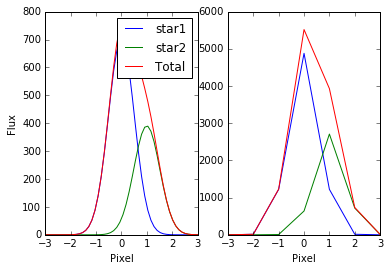

In [3]:
fig=plt.figure()
ax=fig.add_subplot(121)
ax.plot(x,starone*0.9,label="star1")
ax.plot(x,startwo,label="star2")
ax.plot(x,starone*0.9+startwo,label="Total")
ax.set_xlabel("Pixel")
ax.set_ylabel("Flux")
ax.legend()
starone_pixel_ec=pixelize(x,starone*0.9,x_pixel)
startwo_pixel_ec=pixelize(x,startwo,x_pixel)
ax2=fig.add_subplot(122)
ax2.plot(x_pixel,starone_pixel_ec,label="star1")
ax2.plot(x_pixel,startwo_pixel_ec,label="star2")
total_ec=starone_pixel_ec+startwo_pixel_ec
ax2.plot(x_pixel,total_ec,label="Total")
ax2.set_xlabel("Pixel")
#ax2.set_ylabel("Flux")
plt.show()

Let's look at the actual dimming of two stars assuming we take a radius equals to one apperture around both stars.

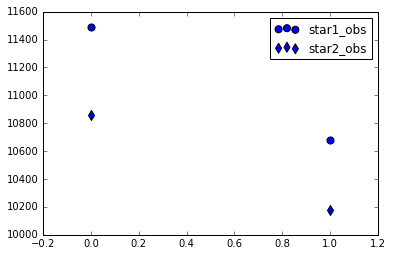

In [4]:
plt.scatter(np.arange(2),[np.sum(total[2:5]),np.sum(total_ec[2:5])],marker='o',s=50,label='star1_obs')
plt.scatter(np.arange(2),[np.sum(total[3:6]),np.sum(total_ec[3:6])],marker='d',s=50,label='star2_obs')
plt.legend()

Both star dimmed, however, star 1 dimed by about 7%, while star 2 dimed by slightly less than 6%.  

### Task:

Try to change the configuration of the two stars and compare the results.

For example: 
- what if the transit happen around Star 2;
- what if the two stars are closer/further away from each other;
- what if the brightness ratio vary;

In [5]:
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [47]:
def make_ROC_curve(testY, predY, name):
    fig2 = plt.figure()
    ax= fig2.add_subplot(1,1,1)
    fpr, tpr, _ = roc_curve(testY, predY)
    ax.plot(fpr, tpr, label = name)
    ax.set_title(('ROC Curve for %s') % name)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
def collect_lc_feature(idlist):
    LCfeature=np.zeros([len(idlist),481])
    count=0
    for i in idlist:
        #print i
        infile="LTFsmall/"+str(i)+".ltf"
        lc=np.loadtxt(infile)[:,1]
        LCfeature[count,0]=i
        LCfeature[count,1:]=lc
        count+=1
    return LCfeature
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['false positives', 'transits'], rotation=45)
    plt.yticks(tick_marks, ['false positives', 'transits'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def fit(model,name,data,cv=True):
    trainX,trainY,testX,testY,X,Y=data
    model.fit(trainX, trainY)
    predY = model.predict(testX)
    f1score = metrics.f1_score(testY, predY)
    cm = metrics.confusion_matrix(testY, predY)
    plot_confusion_matrix(cm)
    predY=model.predict_proba(testX)[:,1]
    rocscore = metrics.roc_auc_score(testY, predY)
    precision, recall, thresholds = metrics.precision_recall_curve(testY, predY)
    aucscore=metrics.auc(precision,recall,reorder=True)
    
    print "#####################################"
    print "Result using",model
    print "f1 score from train test split %f" % f1score
    print "roc score from train test split %f" % rocscore
    print "auc score from train test split %f" % aucscore
    if cv:
        f1cvscore= cross_val_score(model, X, Y, cv = 5, scoring = 'f1')
        cvscore= cross_val_score(model, X, Y, cv = 5, scoring = 'roc_auc')
        print "roc_auc score from CV5 %f +- %f" % (np.mean(cvscore),np.std(cvscore))
        print "f1 score from CV5 %f +- %f" % (np.mean(f1cvscore),np.std(f1cvscore))
    
    
    print cm
    make_ROC_curve(testY,predY,name)
    return

In [7]:
df=pd.read_csv("TESSfield_19h_44d_combinedfeatures.csv")

Let's first have compare the Manuel selected signals with the catalog selected signals. 

As a reminder: 
- **Manuel Y** is those signals selected by human eye as looks like transit shape
- **Catalog Y** is those stars have signals injected in them at the original input catalog that we determined have enough signal to noise to be recovered 


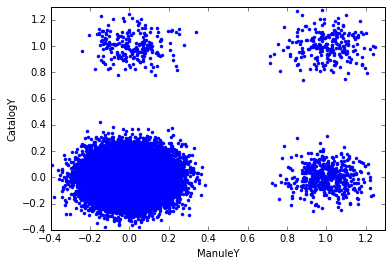

In [8]:
#print df.shape
plt.plot(df['ManuleY']+np.random.randn(df.shape[0])*0.1,df['CatalogY']+np.random.randn(df.shape[0])*0.1,'.')
plt.xlim([-0.4,1.3])
plt.ylim([-0.4,1.3])
plt.xlabel('ManuleY')
plt.ylabel('CatalogY')

There are four groups of cluster above: 
- left bottom corner: manule selection determines most of the stars without a signal correctly.
- right top corner: manule selection determines some of the stars with a catalog signal correctly. 
- left top coner: singals that's not sensitive to human eyes. 
- right bottom coner: **why would signals that's not in catalog appears to be ture to human eye**?

The answer to the question is blending. And our task today is to further distinuish the stars affected by blending and those with true astrophysical signals.

In [9]:
Manule_selected=df.loc[df['ManuleY']==1,:]
Manule_selected.shape

(700, 32)

We drop all the irrelevant columns and all the informations from catalog to creat our innitial feature set.

In [10]:
X=Manule_selected.drop(['Ids','CatalogY','ManuleY','CombinedY','Catalog_Period','Depth','Catalog_Epoch','SNR','Catmag','CatX','CatY'],axis=1)

In [11]:
Y=Manule_selected['CatalogY']

In [12]:
trainX, testX, trainY, testY= train_test_split(X, Y,test_size = 0.2)
data=[trainX,trainY,testX,testY,X,Y]
print X.shape, Y[Y==1].shape

(700, 21) (235,)


This is a slightly inbalanced sample, with the false sample twice as large as the true samples.

#####################################
Result using RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
f1 score from train test split 0.297297
roc score from train test split 0.616596
auc score from train test split 0.119950
roc_auc score from CV5 0.697575 +- 0.054884
[[77 19]
 [33 11]]


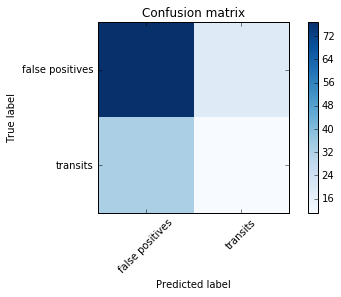

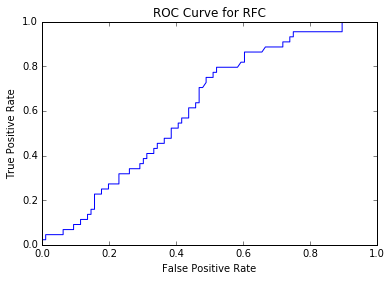

In [26]:
model=RandomForestClassifier(n_estimators=3000,n_jobs=-1)
name="RFC"
fit(model,name,data)

Note that we added the new auc score which computes the area under the precision recall curve.

#####################################
Result using GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=3000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
f1 score from train test split 0.417582
roc score from train test split 0.611979
auc score from train test split 0.167026
roc_auc score from CV5 0.656509 +- 0.037402
[[68 28]
 [25 19]]


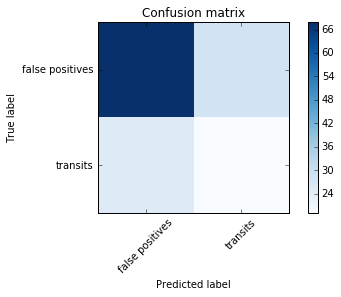

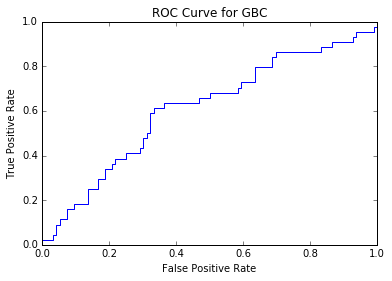

In [27]:
model=GradientBoostingClassifier(n_estimators=3000)
name="GBC"
fit(model,name,data)

#####################################
Result using XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=3000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
f1 score from train test split 0.395349
roc score from train test split 0.612926
auc score from train test split 0.142112
roc_auc score from CV5 0.690231 +- 0.053082
[[71 25]
 [27 17]]


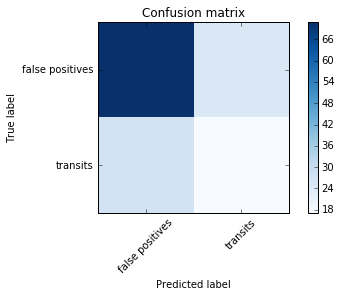

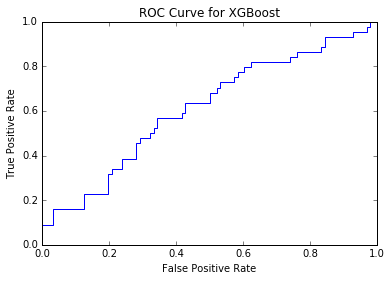

In [28]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=3000)
model.fit(trainX,trainY)
name="XGBoost"
fit(model,name,data)

Let's make some new features: 
One feature that makes sense is the to compare the detected period of planet with any other detected signals and compute an dimentionless distance. 

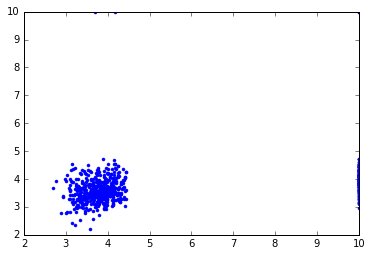

In [84]:
import scipy as sp
from scipy import special
def find_distance(Parr,Earr,threshold=0.005):
    #print Parr
    dist_P=np.zeros(len(Parr))+0.5
    dist_E=np.zeros(len(Parr))+0.5
    for i in xrange(len(Parr)):
        for j in xrange(len(Parr)):
            if i==j:
                continue
            if Parr[j]>Parr[i]:
                delt_P= np.abs(np.abs(Parr[j]-Parr[i])/Parr[i]-round(np.abs(Parr[j]-Parr[i])/Parr[i]))
            else:
                delt_P= np.abs(np.abs(Parr[j]-Parr[i])/Parr[j]-round(np.abs(Parr[j]-Parr[i])/Parr[j]))
            if dist_P[i]>delt_P:
                dist_P[i]=delt_P
            
            delt_E=np.abs(np.abs(Earr[j]-Earr[i])/Parr[i]-round(np.abs(Earr[j]-Earr[i])/Parr[i]))
            if dist_E[i]>delt_E:
                dist_E[i]=delt_E
        if dist_P[i]==0:
            dist_P[i]=10
        else: 
            dist_P[i]=np.sqrt(2)*sp.special.erfcinv(dist_P[i])
        #print i, dist_P[i]
        if dist_E[i]==0:
            dist_E[i]=10
        else:
            dist_E[i]=np.sqrt(2)*sp.special.erfcinv(dist_E[i])
    return [dist_P,dist_E]
#add back the magnitude of stars from the catalog
X=Manule_selected.drop(['Ids','CatalogY','ManuleY','CombinedY','Catalog_Period','Depth','Catalog_Epoch','SNR','CatX','CatY'],axis=1)
Pdist,Edist=find_distance(np.array(X['BLS_Period_1_0']),np.array(X['BLS_Tc_1_0']))
X['dist_E']=Edist
X['dist_P']=Pdist
X['diff_mag']=X['Catmag']-X['BLS_OOTmag_1_0']
plt.plot(Pdist,Edist,'.')

In [85]:
trainX, testX, trainY, testY= train_test_split(X, Y,test_size = 0.2)
data=[trainX,trainY,testX,testY,X,Y]
print X.shape, Y[Y==1].shape

(700, 25) (235,)


#####################################
Result using RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
f1 score from train test split 0.376812
roc score from train test split 0.550904
auc score from train test split 0.163879
roc_auc score from CV5 0.688790 +- 0.044227
f1 score from CV5 0.362331 +- 0.192535
[[84  9]
 [34 13]]


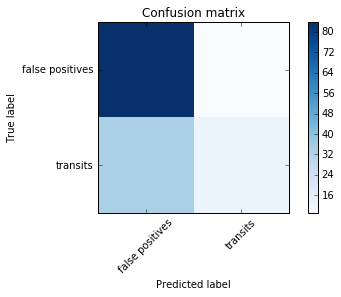

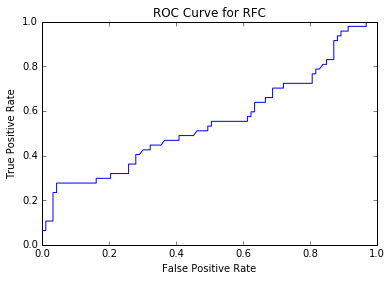

In [50]:
model=RandomForestClassifier(n_estimators=5000,class_weight={0:1,1:3},n_jobs=-1)
name="RFC"
fit(model,name,data)

#####################################
Result using GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=3000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
f1 score from train test split 0.425532
roc score from train test split 0.560055
auc score from train test split 0.103696
roc_auc score from CV5 0.661542 +- 0.039940
f1 score from CV5 0.461036 +- 0.081371
[[66 27]
 [27 20]]


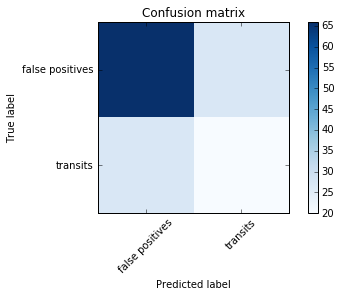

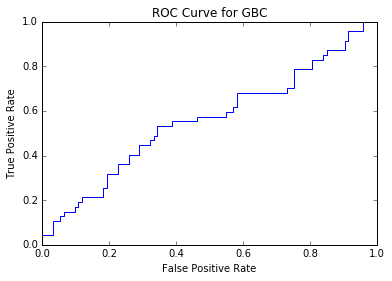

In [51]:
model=GradientBoostingClassifier(n_estimators=3000)
name="GBC"
fit(model,name,data)

#####################################
Result using XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0, learning_rate=0.001, max_delta_step=0, max_depth=18,
       min_child_weight=1.0, missing=None, n_estimators=3000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
f1 score from train test split 0.494118
roc score from train test split 0.697781
auc score from train test split 0.291113
roc_auc score from CV5 0.724365 +- 0.034988
f1 score from CV5 0.504518 +- 0.052050
[[76 17]
 [26 21]]


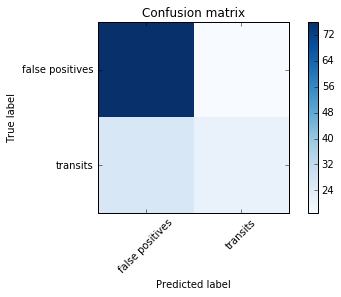

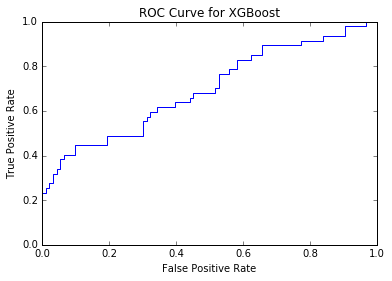

In [86]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=3000,max_depth=18,colsample_bytree=1.0,min_child_weight=1.0,learning_rate=0.001)
model.fit(trainX,trainY)
name="XGBoost"
fit(model,name,data)

In [21]:
featurelist=X.columns
rfc= RandomForestClassifier(n_estimators=3000)
rfc.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print indices.shape,trainX.shape
# Print the feature ranking
print("Feature ranking:")
threshold=0.03
droplist=[]
for f in range(X.shape[1]):
    try:
        if importances[indices[f]]<threshold:
            droplist.append(featurelist[indices[f]])
        print("%d. feature %d (%s %f)" % (f + 1, indices[f], featurelist[indices[f]],importances[indices[f]]))
    except:
        pass

(26,) (560, 26)
Feature ranking:
1. feature 22 (Catmag 0.065428)
2. feature 3 (BLS_SR_1_0 0.062854)
3. feature 5 (BLS_Depth_1_0 0.059267)
4. feature 18 (BLS_Whitenoise_1_0 0.050444)
5. feature 8 (BLS_OOTmag_1_0 0.049806)
6. feature 11 (BLS_deltaChi2_1_0 0.049762)
7. feature 24 (dist_E 0.047468)
8. feature 25 (dist_P 0.043370)
9. feature 19 (BLS_SignaltoPinknoise_1_0 0.040501)
10. feature 7 (BLS_Qingress_1_0 0.040213)
11. feature 20 (CatX 0.039680)
12. feature 4 (BLS_SDE_1_0 0.039580)
13. feature 12 (BLS_fraconenight_1_0 0.039018)
14. feature 9 (BLS_i1_1_0 0.036927)
15. feature 17 (BLS_Rednoise_1_0 0.036609)
16. feature 10 (BLS_i2_1_0 0.035976)
17. feature 2 (BLS_SN_1_0 0.035917)
18. feature 21 (CatY 0.031186)
19. feature 23 (Ids.1 0.031009)
20. feature 0 (BLS_Period_1_0 0.028615)
21. feature 6 (BLS_Qtran_1_0 0.028235)
22. feature 16 (BLS_Npointsaftertransit_1_0 0.025640)
23. feature 13 (BLS_Npointsintransit_1_0 0.024095)
24. feature 15 (BLS_Npointsbeforetransit_1_0 0.022962)
25. featur

In [23]:
X_selected=X.drop(droplist,axis=1)
X_selected.head()

,BLS_SN_1_0,BLS_SR_1_0,BLS_SDE_1_0,BLS_Depth_1_0,BLS_Qingress_1_0,BLS_OOTmag_1_0,BLS_i1_1_0,BLS_i2_1_0,BLS_deltaChi2_1_0,BLS_fraconenight_1_0,BLS_Rednoise_1_0,BLS_Whitenoise_1_0,BLS_SignaltoPinknoise_1_0,CatX,CatY,Catmag,Ids.1,dist_E,dist_P
400,12.53336,0.00634,7.57704,0.03424,0.36902,7.37420,0.94231,1.02001,-403.87175,0.05159,0.00310,0.00829,34.89784,325.972487,11.685035,12.568078,401,3.291958,4.438688
402,12.73811,0.00347,7.72676,0.01991,0.40737,7.02694,0.44397,0.52002,-307.10972,0.04950,0.00170,0.00463,36.61236,324.873895,14.207794,13.762556,403,4.520055,3.999749
403,12.55868,0.00386,7.72838,0.02155,0.38419,7.23076,0.44914,0.52277,-317.47072,0.05163,0.00183,0.00495,36.48016,323.930348,9.362986,13.920750,404,3.512163,4.165658
505,8.73484,0.00179,9.24720,0.01374,0.24426,8.69045,0.01177,0.03695,-53.01366,0.25765,0.00099,0.00828,9.67684,191.119809,0.133972,13.979692,506,4.524330,3.158509
593,11.14045,0.01313,8.34805,0.08545,0.22411,8.64580,0.19679,0.22928,-561.32033,0.22492,0.00102,0.00968,59.23343,81.152584,6.024888,13.277000,594,3.510703,3.500817


#####################################
Result using RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
f1 score from train test split 0.277778
roc score from train test split 0.614228
auc score from train test split 0.107593
roc_auc score from CV5 0.692839
[[78 18]
 [34 10]]


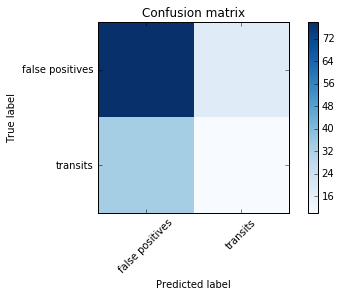

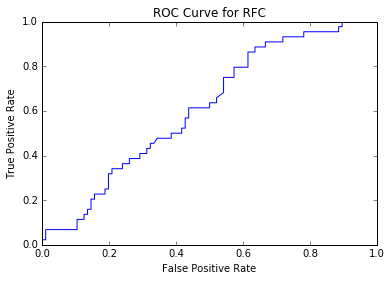

In [24]:
model=RandomForestClassifier(n_estimators=3000,n_jobs=-1,class_weight='balanced_subsample')
name="RFC"
fit(model,name,data)

### Task:
Try to improve the result:
- create more features, for example calculate the minimum distance to another star. 
- Fine tune the algorithms.